# Imports

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Carregamento e configurações

In [2]:
data = pd.read_csv("Dataset.csv")

In [3]:
print(data.head())

   Idade  Renda Anual (em $)    Gênero  Tempo no Site (min) Anúncio Clicado  \
0   29.0             30000.0  Feminino             5.741706             Não   
1   58.0             50000.0  Feminino            21.885505             Sim   
2   50.0             70000.0  Feminino             6.121339             Não   
3   21.0            100000.0  Feminino            16.264925             Não   
4   59.0             50000.0  Feminino            28.235667             Sim   

   Compra (0 ou 1)  
0                0  
1                0  
2                1  
3                0  
4                1  


# Análise exploratória dos dados

### Metadados

In [4]:
info_data = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Idade                190 non-null    float64
 1   Renda Anual (em $)   189 non-null    float64
 2   Gênero               193 non-null    object 
 3   Tempo no Site (min)  200 non-null    float64
 4   Anúncio Clicado      190 non-null    object 
 5   Compra (0 ou 1)      200 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 9.5+ KB


In [5]:
missing_values = data.isnull().sum()
missing_values

Idade                  10
Renda Anual (em $)     11
Gênero                  7
Tempo no Site (min)     0
Anúncio Clicado        10
Compra (0 ou 1)         0
dtype: int64

In [6]:
desc_data = data.describe()
desc_data

,Idade,Renda Anual (em $),Tempo no Site (min),Compra (0 ou 1)
count,190.000000,189.000000,200.000000,200.000000
mean,38.510526,58253.968254,17.349090,0.330000
std,12.679918,25612.061811,7.724088,0.471393
min,18.000000,30000.000000,-1.000000,0.000000
25%,28.000000,30000.000000,10.860240,0.000000
50%,38.000000,50000.000000,18.197552,0.000000
75%,50.000000,70000.000000,23.887341,1.000000
max,59.000000,100000.000000,29.853484,1.000000


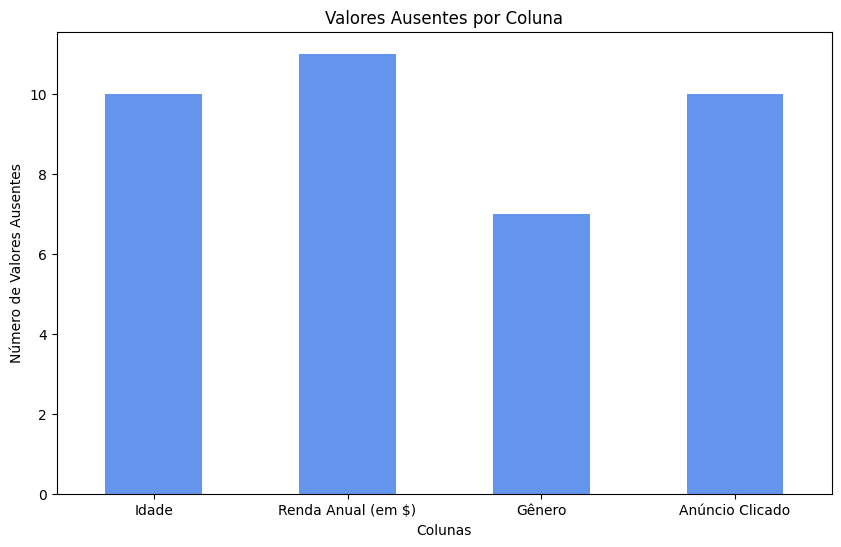

In [7]:
missing_data = data.isnull().sum()

plt.figure(figsize=(10, 6))
missing_data[missing_data > 0].plot(kind='bar', color='#6495ED')
plt.title('Valores Ausentes por Coluna')
plt.xlabel('Colunas')
plt.xticks(rotation=0)
plt.ylabel('Número de Valores Ausentes')
plt.show()

In [8]:
data = data[(data['Idade'] >= 0) & (data['Idade'] <= 101)]
data = data[(data['Tempo no Site (min)'] >= 0) & (data['Tempo no Site (min)'] <= 1440)]
data = data[data['Gênero'].isin(['Masculino', 'Feminino'])]
data = data[data['Anúncio Clicado'].isin(['Não', 'Sim'])]
data = data.dropna(subset=['Idade', 'Renda Anual (em $)', 'Tempo no Site (min)', 'Gênero', 'Anúncio Clicado'])

In [9]:
desc_data = data.describe()
desc_data

,Idade,Renda Anual (em $),Tempo no Site (min),Compra (0 ou 1)
count,165.000000,165.000000,165.000000,165.000000
mean,39.254545,59515.151515,17.994546,0.321212
std,12.829394,26221.524872,7.191249,0.468364
min,18.000000,30000.000000,5.052596,0.000000
25%,28.000000,30000.000000,12.616978,0.000000
50%,39.000000,50000.000000,18.312317,0.000000
75%,51.000000,70000.000000,24.047671,1.000000
max,59.000000,100000.000000,29.853484,1.000000


### Distribuição de Variáveis

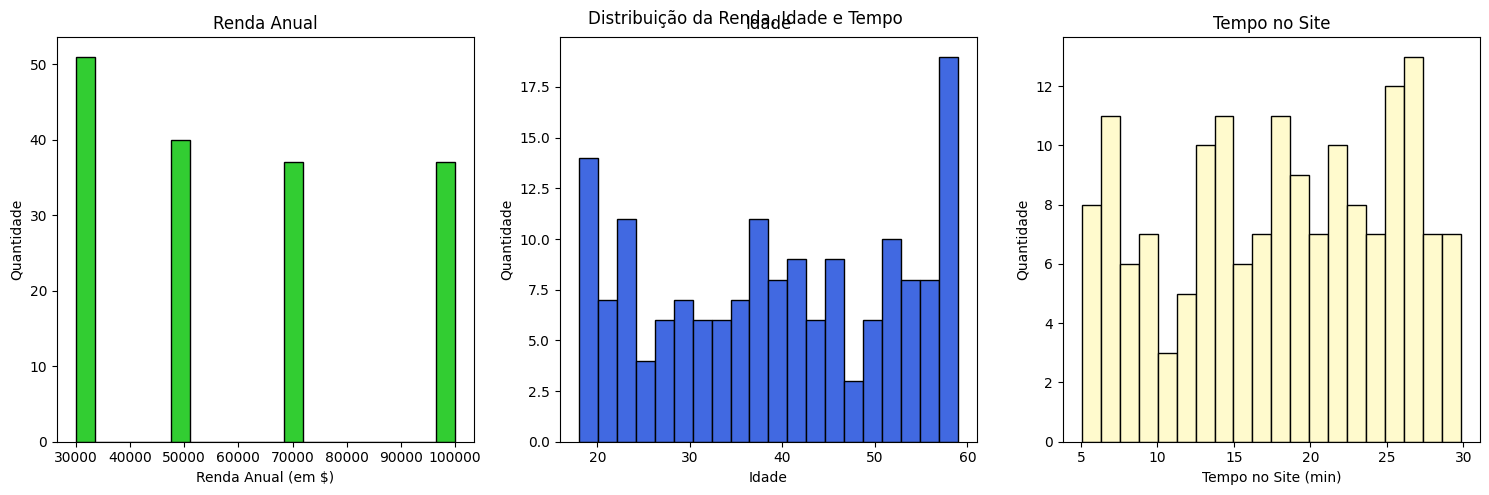

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(data['Renda Anual (em $)'], bins=20, color='limegreen', edgecolor='black')
axs[0].set_title('Renda Anual')
axs[0].set_xlabel('Renda Anual (em $)')
axs[0].set_ylabel('Quantidade')

axs[1].hist(data['Idade'], bins=20, color='royalblue', edgecolor='black')
axs[1].set_title('Idade')
axs[1].set_xlabel('Idade')
axs[1].set_ylabel('Quantidade')

axs[2].hist(data['Tempo no Site (min)'], bins=20, color='lemonchiffon', edgecolor='black')
axs[2].set_title('Tempo no Site')
axs[2].set_xlabel('Tempo no Site (min)')
axs[2].set_ylabel('Quantidade')

plt.tight_layout()

fig.suptitle('Distribuição da Renda, Idade e Tempo')

plt.show()

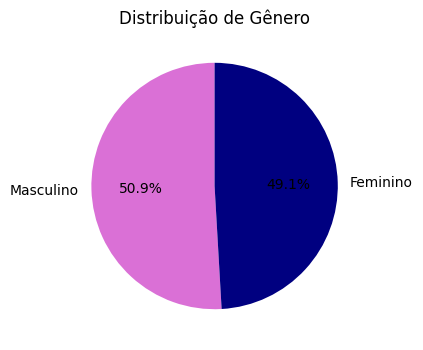

In [11]:
genero_counts = data['Gênero'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(genero_counts, labels=genero_counts.index, autopct='%1.1f%%', startangle=90, colors=['orchid', 'navy'])
plt.title('Distribuição de Gênero')
plt.show()

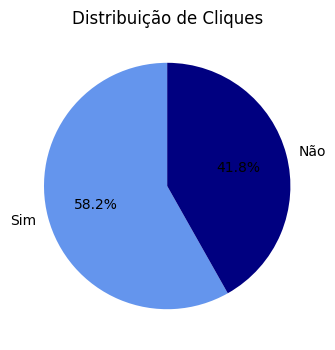

In [12]:
genero_counts = data['Anúncio Clicado'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(genero_counts, labels=genero_counts.index, autopct='%1.1f%%', startangle=90, colors=['cornflowerblue', 'navy'])
plt.title('Distribuição de Cliques')
plt.show()

### Relação entre as variáveis e o target

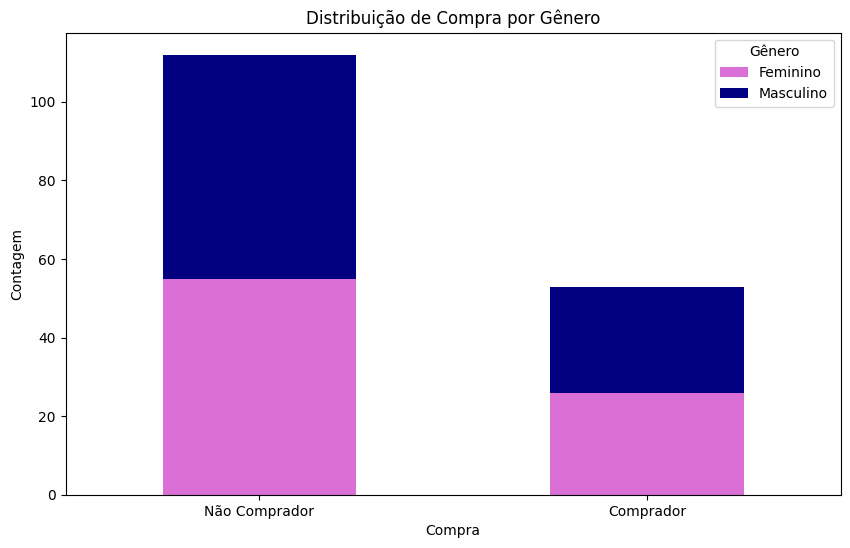

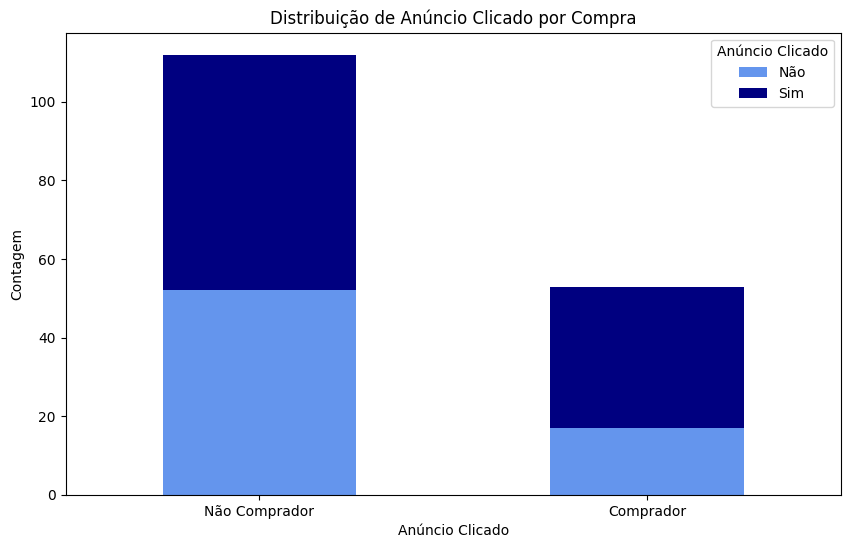

In [13]:
gender_purchase = data.groupby(['Compra (0 ou 1)', 'Gênero']).size().unstack()
gender_colors = ['orchid', 'navy']
gender_purchase.plot(kind='bar', stacked=True, figsize=(10, 6), color=gender_colors)
plt.title('Distribuição de Compra por Gênero')
plt.xlabel('Compra')
plt.xticks(ticks=[0, 1], labels=['Não Comprador', 'Comprador'], rotation=0)
plt.ylabel('Contagem')
plt.legend(title='Gênero', loc='upper right', labels=['Feminino', 'Masculino'])
plt.show()

ad_purchase = data.groupby(['Compra (0 ou 1)', 'Anúncio Clicado']).size().unstack()
ad_purchase.plot(kind='bar', stacked=True, figsize=(10, 6), color=['cornflowerblue', 'navy'])
plt.title('Distribuição de Anúncio Clicado por Compra')
plt.xlabel('Anúncio Clicado')
plt.xticks(ticks=[0, 1], labels=['Não Comprador', 'Comprador'], rotation=0)
plt.ylabel('Contagem')
plt.legend(title='Anúncio Clicado', loc='upper right', labels=['Não', 'Sim'])
plt.show()

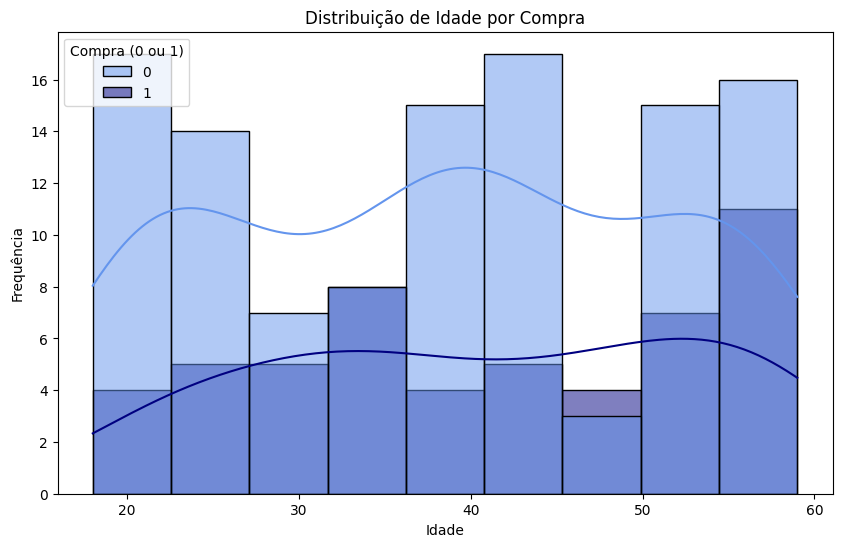

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Idade', hue='Compra (0 ou 1)', kde=True, palette=['cornflowerblue', 'navy'])
plt.title('Distribuição de Idade por Compra')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

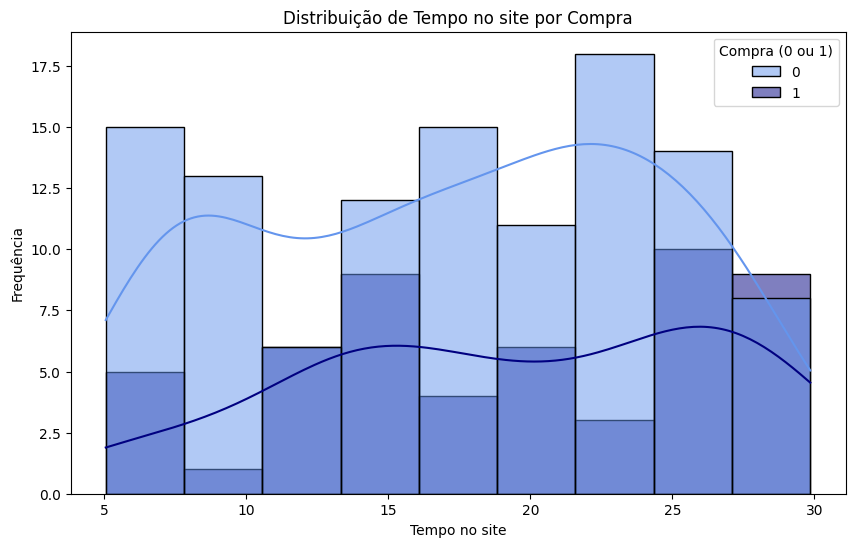

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Tempo no Site (min)', hue='Compra (0 ou 1)', kde=True, palette=['cornflowerblue', 'navy'])
plt.title('Distribuição de Tempo no site por Compra')
plt.xlabel('Tempo no site')
plt.ylabel('Frequência')
plt.show()

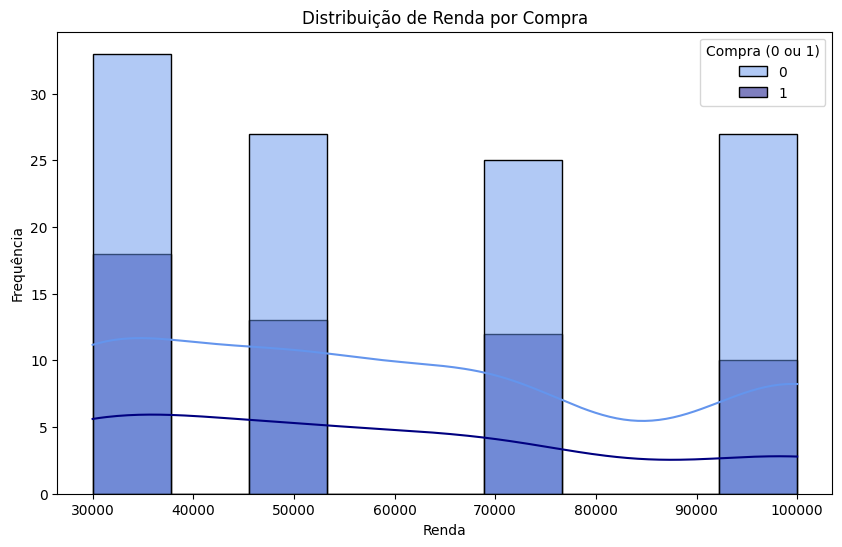

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Renda Anual (em $)', hue='Compra (0 ou 1)', kde=True, palette=['cornflowerblue', 'navy'])
plt.title('Distribuição de Renda por Compra')
plt.xlabel('Renda')
plt.ylabel('Frequência')
plt.show()

# Pré-processamento

In [17]:
scaler = StandardScaler()
data['Idade_padronizada'] = scaler.fit_transform(data[['Idade']])
data['Renda_padronizada'] = scaler.fit_transform(data[['Renda Anual (em $)']])
data['Tempo_padronizada'] = scaler.fit_transform(data[['Tempo no Site (min)']])

In [18]:
encoder = LabelEncoder()
data['Gênero_codificado'] = encoder.fit_transform(data['Gênero'])
data['Anúncio_codificado'] = encoder.fit_transform(data['Anúncio Clicado'])

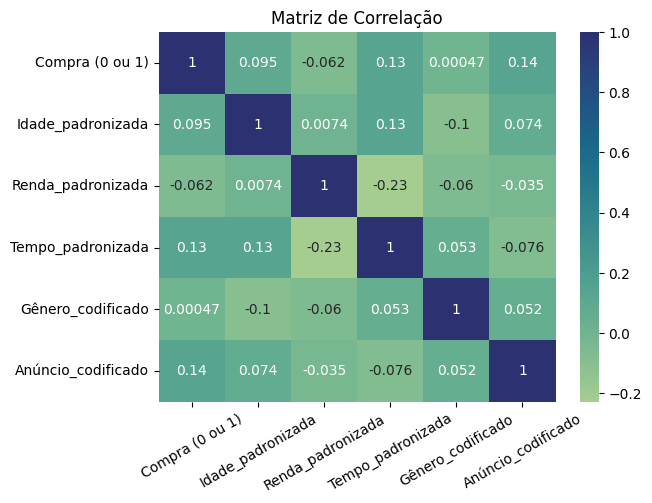

In [19]:
colunas = ['Compra (0 ou 1)', 'Idade_padronizada', 'Renda_padronizada', 'Tempo_padronizada', 'Gênero_codificado', 'Anúncio_codificado']
corr_matrix = data[colunas].corr()

sns.heatmap(corr_matrix, annot=True, cmap="crest")
plt.xticks(rotation=30)
plt.title('Matriz de Correlação')
plt.show()

In [20]:
data

,Idade,Renda Anual (em $),Gênero,Tempo no Site (min),Anúncio Clicado,Compra (0 ou 1),Idade_padronizada,Renda_padronizada,Tempo_padronizada,Gênero_codificado,Anúncio_codificado
0,29.0,30000.0,Feminino,5.741706,Não,0,-0.801734,-1.129034,-1.709041,0,0
1,58.0,50000.0,Feminino,21.885505,Sim,0,1.465581,-0.363980,0.542716,0,1
2,50.0,70000.0,Feminino,6.121339,Não,1,0.840115,0.401074,-1.656089,0,0
3,21.0,100000.0,Feminino,16.264925,Não,0,-1.427200,1.548655,-0.241250,0,0
4,59.0,50000.0,Feminino,28.235667,Sim,1,1.543764,-0.363980,1.428444,0,1
...,...,...,...,...,...,...,...,...,...,...,...
192,34.0,70000.0,Feminino,9.338113,Sim,0,-0.410818,0.401074,-1.207410,0,1
193,42.0,50000.0,Feminino,22.373777,Não,0,0.214649,-0.363980,0.610820,0,0
194,45.0,100000.0,Masculino,13.652493,Sim,0,0.449199,1.548655,-0.605635,1,1
197,54.0,30000.0,Feminino,25.562014,Não,1,1.152848,-1.129034,1.055520,0,0


In [418]:
labels = ['Idade_padronizada', 'Renda_padronizada', 'Tempo_padronizada', 'Anúncio_codificado', 'Gênero_codificado']
X = data[labels]
y = data['Compra (0 ou 1)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construção do Modelo de Classificação

### Comparação dos modelos simples

c:\Users\fsfse\OneDrive\Documentos\GitHub\HouseBuyers\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0        Random Forest      0.66   0.555556  0.277778   0.37037  0.546007
1  Logistic Regression      0.64   0.000000  0.000000   0.00000  0.588542
2        Decision Tree      0.48   0.214286  0.166667   0.18750  0.411458


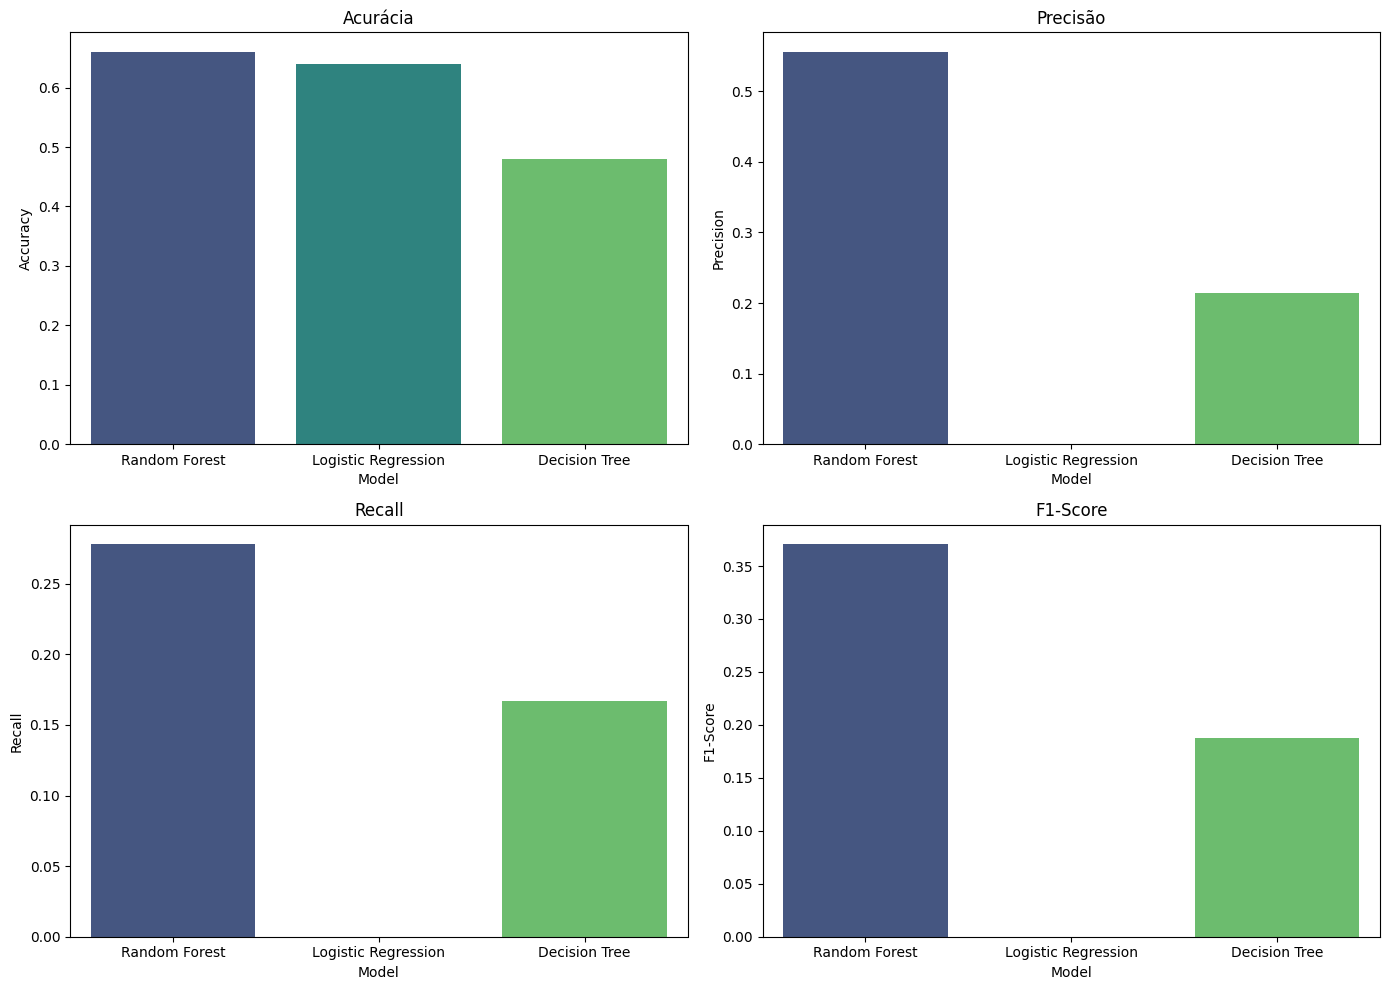

In [26]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

model_results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    model_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

model_comparison = pd.DataFrame(model_results)

print(model_comparison)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x='Model', y='Accuracy', data=model_comparison, ax=ax[0, 0], palette='viridis', hue='Model')
ax[0, 0].set_title('Acurácia')

sns.barplot(x='Model', y='Precision', data=model_comparison, ax=ax[0, 1], palette='viridis', hue='Model')
ax[0, 1].set_title('Precisão')

sns.barplot(x='Model', y='Recall', data=model_comparison, ax=ax[1, 0], palette='viridis', hue='Model')
ax[1, 0].set_title('Recall')

sns.barplot(x='Model', y='F1-Score', data=model_comparison, ax=ax[1, 1], palette='viridis', hue='Model')
ax[1, 1].set_title('F1-Score')

plt.tight_layout()
plt.show()

### Modelo simples Random Forest

In [80]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)

In [81]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_rf:.4f}")

Acurácia: 0.6200


[[27  5]
 [14  4]]


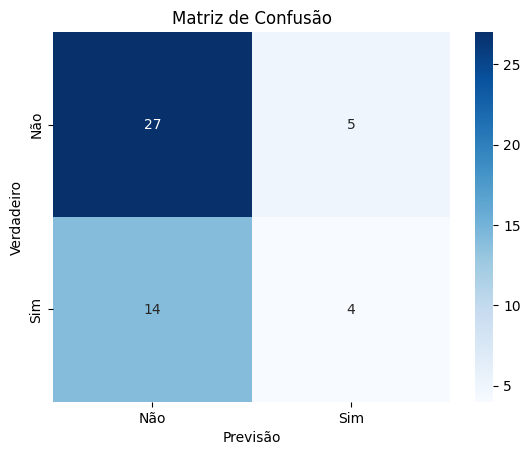

In [82]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [83]:
print(classification_report(y_test, y_pred_rf, target_names=['Não Comprador', 'Comprador']))

               precision    recall  f1-score   support

Não Comprador       0.66      0.84      0.74        32
    Comprador       0.44      0.22      0.30        18

     accuracy                           0.62        50
    macro avg       0.55      0.53      0.52        50
 weighted avg       0.58      0.62      0.58        50



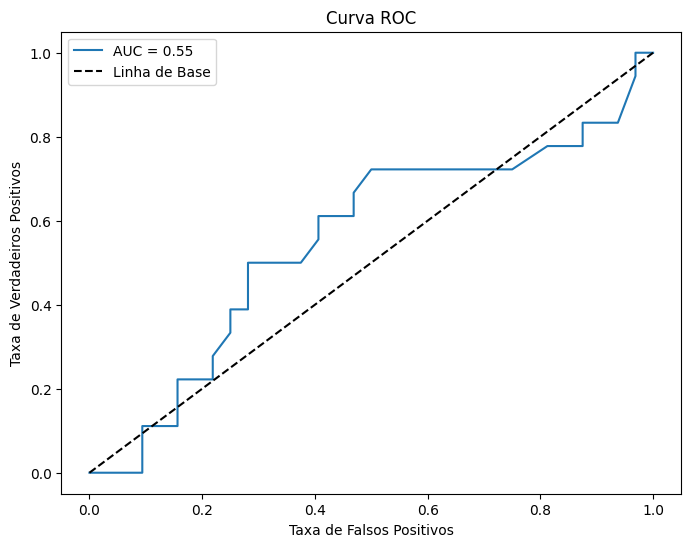

In [84]:
y_prob_rf = random_forest.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_score = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

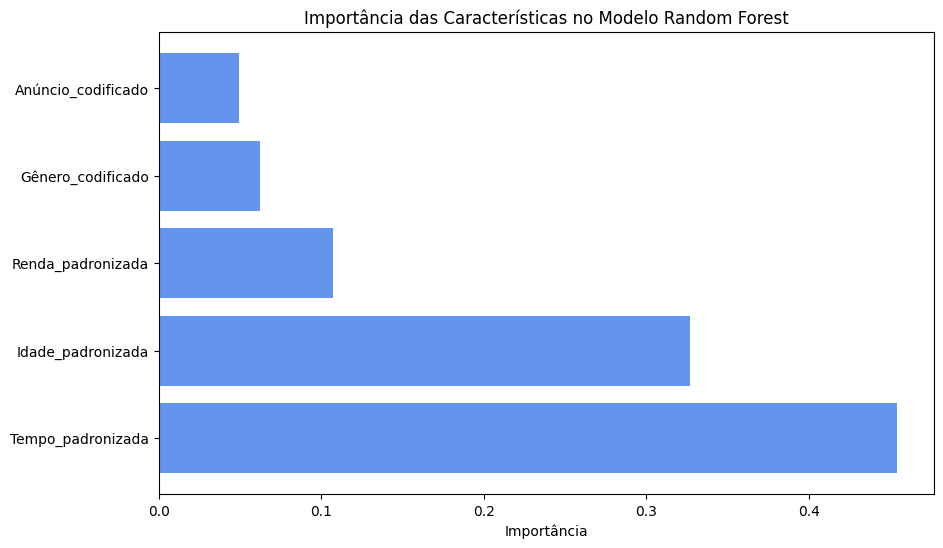

              Feature  Importance
2   Tempo_padronizada    0.454259
0   Idade_padronizada    0.326881
1   Renda_padronizada    0.107142
4   Gênero_codificado    0.062394
3  Anúncio_codificado    0.049324


In [85]:
importances = random_forest.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='cornflowerblue')
plt.xlabel('Importância')
plt.title('Importância das Características no Modelo Random Forest')
plt.show()

print(feature_importance_df)

# Aprimorando o modelo

### Pesquisa de hiperparâmetros

In [ ]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, {0: 1, 1: 2}, {0: 1, 1: 3}],
    'bootstrap': [False, True]
}

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=5,            
    verbose=0,       
    n_jobs=2        
)

grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)

print("Melhor F1-Score (validação cruzada):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Melhores hiperparâmetros: {'bootstrap': False, 'class_weight': {0: 1, 1: 2}, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Melhor F1-Score (validação cruzada): 0.36897651368239603


In [411]:
model_best_f1score = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    max_features='log2',
    criterion='gini',
    bootstrap=False,
    min_samples_leaf=2,
    min_samples_split=10,
    class_weight= {0: 1, 1: 2}
)

scores = cross_val_score(model_best_f1score, X_train, y_train, cv=5, scoring='accuracy')
print("Scores por fold:", scores)
print("Média da validação cruzada:", scores.mean())

model_best_f1score.fit(X_train, y_train)

y_pred_f1score = model_best_f1score.predict(X_test)

Scores por fold: [0.69565217 0.52173913 0.52173913 0.56521739 0.47826087]
Média da validação cruzada: 0.5565217391304348


[[25  7]
 [12  6]]


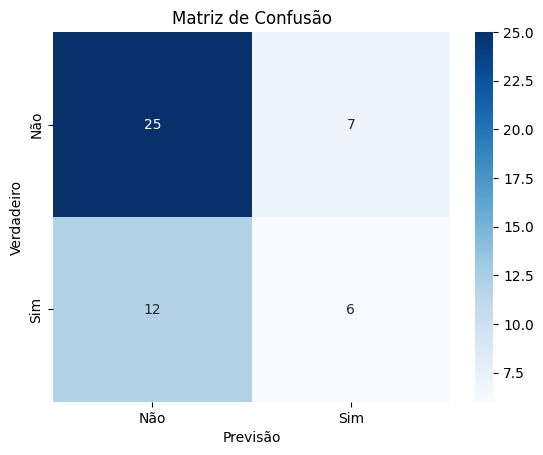

In [413]:
conf_matrix_f1score = confusion_matrix(y_test, y_pred_f1score)
print(conf_matrix_f1score)

sns.heatmap(conf_matrix_f1score, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [414]:
print(classification_report(y_test, y_pred_f1score, target_names=['Não Comprador', 'Comprador']))

               precision    recall  f1-score   support

Não Comprador       0.68      0.78      0.72        32
    Comprador       0.46      0.33      0.39        18

     accuracy                           0.62        50
    macro avg       0.57      0.56      0.56        50
 weighted avg       0.60      0.62      0.60        50



In [308]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, {0: 1, 1: 2}, {0: 1, 1: 3}],
    'bootstrap': [False, True]
}

scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=5,            
    verbose=0,       
    n_jobs=2        
)

grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)

print("Melhor F1-Score (validação cruzada):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Melhores hiperparâmetros: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Melhor F1-Score (validação cruzada): 0.7304347826086955


In [420]:
model_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='log2',
    criterion='gini',
    bootstrap=True,
    min_samples_leaf=4,
    min_samples_split=5,
    class_weight= None
)

scores = cross_val_score(model_best, X_train, y_train, cv=5, scoring='accuracy')
print("Scores por fold:", scores)
print("Média da validação cruzada:", scores.mean())

model_best.fit(X_train, y_train)

y_pred_best = model_best.predict(X_test)

Scores por fold: [0.69565217 0.65217391 0.69565217 0.73913043 0.73913043]
Média da validação cruzada: 0.7043478260869565


[[29  3]
 [16  2]]


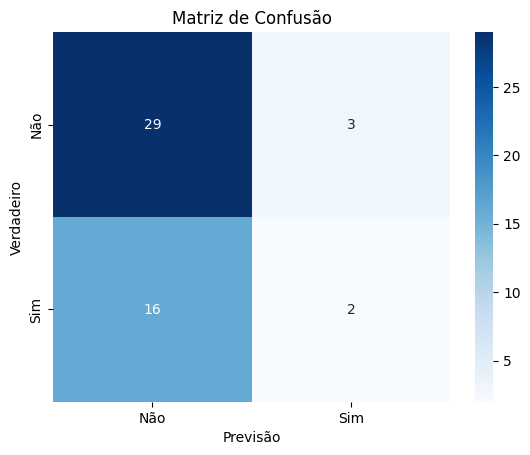

In [421]:
conf_matrix = confusion_matrix(y_test, y_pred_best)
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [408]:
print(classification_report(y_test, y_pred_best, target_names=['Não Comprador', 'Comprador']))

               precision    recall  f1-score   support

Não Comprador       0.67      0.94      0.78        32
    Comprador       0.60      0.17      0.26        18

     accuracy                           0.66        50
    macro avg       0.63      0.55      0.52        50
 weighted avg       0.64      0.66      0.59        50



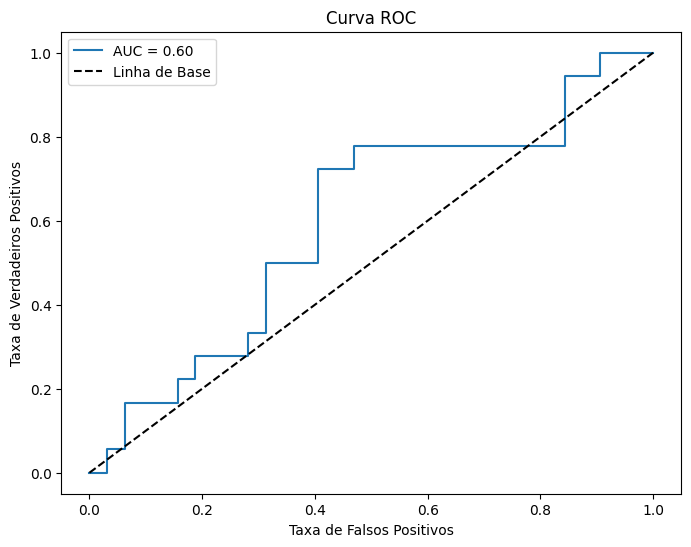

In [409]:
y_prob_best = model_best.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
auc_score = roc_auc_score(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()